# Self-supervised and multi-modal representation Learning: Notebook 2

Here we will build a simple encoder for light curves, and try to train it to learn useful representation via masked autoencoding (i.e., predicting a missing part of the light curve).

## Light curve encoding via masked self-supervised learning

In [56]:
import sys, os
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py 
import torch
from torch.utils.data import DataLoader

from src.dataloader import SimulationLightcurveDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data loading and pre-processing

Let's start by loading the BTS data. The data contain variable number of light curves. For those with >100 observations pick 100 at random. Pad the shorter ones with zeros up to a length of 100. We'll also create a padding mask to be used in the encoder.

In [4]:
scotch = h5py.File("./data/sim_data/scotch_z3.hdf5", "r")

In [5]:
from collections import Counter
fullCount = 0
print('overview over dataset')
for key in list(scotch['TransientTable'].keys()):
    for key2 in list(scotch['TransientTable'][key].keys()):
        Nclass = len(scotch['TransientTable'][key][key2]['GID'][:])
        fullCount += Nclass
        print("%i %s events in the catalogue." %( Nclass, key2))
print("Total Number of Transients:")
print(fullCount)

overview over dataset
10000 AGN01 events in the catalogue.
90000 AGN20 events in the catalogue.
50000 KN_B19 events in the catalogue.
50000 KN_K17 events in the catalogue.
100000 SLSN-I events in the catalogue.
633000 SNII+HostXT_V19 events in the catalogue.


633000 SNII-NMF events in the catalogue.
633000 SNII-Templates events in the catalogue.
50000 SNIIn+HostXT_V19 events in the catalogue.
50000 SNIIn-MOSFIT events in the catalogue.
100000 SNIIb+HostXT_V19 events in the catalogue.
100000 SNIa-91bg events in the catalogue.
2000000 SNIa-SALT2 events in the catalogue.
100000 SNIax events in the catalogue.
50000 SNIb+HostXT_V19 events in the catalogue.
50000 SNIb-Templates events in the catalogue.
50000 SNIc+HostXT_V19 events in the catalogue.
50000 SNIc-Templates events in the catalogue.
100000 SNIcBL+HostXT_V19 events in the catalogue.
101000 TDE events in the catalogue.
Total Number of Transients:
5000000


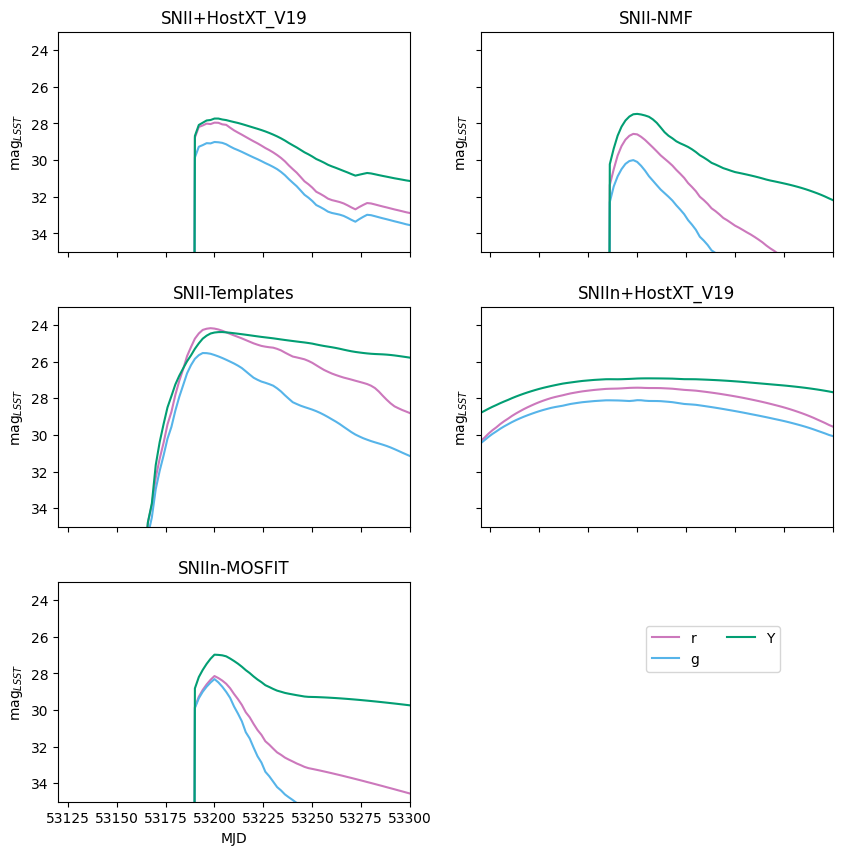

In [6]:
# Getting transients 
scotch_transients = scotch['TransientTable']
# SNII table
SNII = scotch_transients['SNII']
SNII_models = list(SNII.keys())
# Choose bands 
bands = 'rgY'
# Plotting
cols = sns.color_palette("colorblind", 10)
cols_hex = cols.as_hex()
cols = np.array([cols[3], cols[1], cols[8], cols[2], cols[9], cols[0], cols[4], cols[5], cols[7],cols[6]])
cols = np.array([sns.color_palette("colorblind", 10)[4], cols[4], cols[3], cols[0], 'tab:red', cols[7]], dtype='object') #u and y probably need changing

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs[2, 1].set_axis_off()
plt.subplots_adjust(hspace=0.25, wspace=0.2)

for i in np.arange(len(SNII_models)):
    model = SNII_models[i]
    SNII_oneModel = SNII[model]
    ax = axs.ravel()[i]
    for j in np.arange(len(bands)):
        ax.plot(SNII_oneModel['MJD'][10], SNII_oneModel['mag_%s'%bands[j]][10], c=cols[j], label=bands[j])
    if i==0:
        ax.legend(bbox_to_anchor=(2.05, -1.7), borderaxespad=0, ncol=2)
    ax.set_ylim((35, 23))
    ax.set_xlim((53120, 53300))
    ax.set_ylabel("mag$_{LSST}$")
    ax.set_title(model)
axs.ravel()[4].set_xlabel("MJD");

In [57]:
# Usage
dataset = SimulationLightcurveDataset('./data/sim_data/scotch_z3.hdf5', transient_types=['SNII', 'SNIa'], bands=['g'], n_max_obs=80)
loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)

# Example of iterating through data loader
for times, datas, masks in loader:
    print(times[0])
    print(datas[0])
    print(masks[0])
    break

/n/home02/gemzhang/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([ 62.,  92., 136., 174., 140.,  56., 198., 128., 190.,  76.,  58.,  48.,
         96.,  40., 180.,  20.,  46.,  18., 152.,  74., 164., 114.,  36., 118.,
        182.,  26., 200., 106.,  38.,  12.,  98., 196.,  84., 144.,   0., 176.,
        158., 126., 134.,  52., 184., 104., 178., 192., 130., 148.,  28.,  10.,
         30.,   8.,  24., 142., 162., 154., 108.,  72.,  94.,  78., 186., 166.,
        122.,  68.,  22., 138.,  66., 132.,  82.,  80., 168., 124.,  16., 102.,
        116., 160.,  90., 112.,  60.,  34., 170.,   4.])
tensor([99.2040, 29.6299, 31.0229, 33.0029, 31.4456, 99.2040, 33.6861, 30.3276,
        33.4737, 99.2040, 99.2040, 99.2040, 29.0967, 99.2040, 33.1843, 99.2040,
        99.2040, 99.2040, 32.6357, 99.2040, 33.1684, 29.5364, 99.2040, 29.7647,
        33.2398, 99.2040, 33.7330, 28.9735, 99.2040, 99.2040, 29.0648, 33.6341,
        99.2040, 31.9356, 99.2040, 33.0601, 32.9404, 30.2127, 30.7973, 99.2040,
        33.2984, 29.0501, 33.1206, 33.5350, 30.4561, 32.3201, 9

### Light curve encoder

We'll start with a simple transformer-based light curve encoder. Since transformers are inherenently permutation-equivariant (i.e., insensitive to ordering -- a permutation of the inputs leads to a corresponding permutation of the outputs), we'll need to add time encodings to "tell" the transformer the time corresponding to each observation. 

This is a simple way to be able to deal with variable-length, heterogeneously sampled light curves. There are many extensions to this basic idea, see e.g.
- https://arxiv.org/abs/2309.16316
- https://arxiv.org/abs/2308.06404
- https://www.aanda.org/articles/aa/full_html/2023/02/aa43928-22/aa43928-22.html

and feel free to implement ideas from these or others, e.g. learnable time encoding bases.

In [21]:
import math

import torch
import torch.nn as nn
import pytorch_lightning as pl

from src.models_multimodal import TransformerWithTimeEmbeddings

PyTorch has a boilerplate Transformer implementation (`nn.TransformerEncoder`), but we'll use a lower-level implementation in `models/transformer_utils.py` for a bit more flexibility if we need it. Feel free to play around with either in the block below, inspecting the outputs and their shape, effect of masking, effect of changing hyperparameters.

Now let's implement the light curve encoder. For more details on the time-encoding via fourier features, please see e.g., [here](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html#Positional-encoding), from where it was adapted. We'll include the time encoding dependence simply by adding the embeddings to the linear embeddings of individual light curve data points.

### Dataset prep and masking

In [58]:
# Convert to torch tensors
mag = torch.Tensor(datas)
time = torch.Tensor(times)
mask = torch.Tensor(masks).to(torch.bool)

# Standardize mag
'''
mag_mean = mag.mean()
mag_std = mag.std()
mag = (mag - mag_mean) / mag_std
'''
# # Standardize time # Don't standardize time, since we'll zero-subtract for simplicity
# time_mean = time.mean()
# time_std = time.std()
# time = (time - time_mean) / time_std

'\nmag_mean = mag.mean()\nmag_std = mag.std()\nmag = (mag - mag_mean) / mag_std\n'

Write a convenience function to get masks for the encoder.

In [32]:
# Convenience function to get random masks

def get_random_mask(padding_mask, f_mask=0.15):
    """ Get a random contiguous masks for the input sequence.
    :param padding_mask: Padding mask (B, T).
    :param f_mask: Fraction of mask to keep.
    :return: Mask (B, T).
    """
    mask = torch.ones_like(padding_mask)
    mask_pred = torch.ones_like(padding_mask)
    for i in range(padding_mask.shape[0]):
        n_obs = padding_mask[i].sum().item()
        n_obs_to_mask = int(n_obs * f_mask)

        inds_padding = torch.where(padding_mask[i] == True)[0]
        inds_perm = torch.randperm(len(inds_padding)) 
        inds_to_keep = inds_padding[inds_perm[n_obs_to_mask:]]
        inds_pred = inds_padding[inds_perm[:n_obs_to_mask]]

        mask[i, inds_to_keep] = False
        mask_pred[i, inds_pred] = False
        '''
        start = torch.randint(0, n_obs - n_obs_to_keep + 1, (1,)).item()
        end = start + n_obs_to_keep

        # Mask containing observations to be kept
        mask[i, start:end] = False  # Mask out observations from start to end
        mask[i, n_obs:] = False

        # Mask only containing observations to be predicted
        mask_pred[i, end:n_obs] = False
        mask_pred[i, :start] = False
        mask_pred[i, start:end] = True
        mask_pred[i, n_obs:] = False
        '''

    return mask, mask_pred

# Test the mask function

f_mask = 0.15

mask_test = mask[3:]
mask_in, mask_pred = get_random_mask(mask_test, f_mask=f_mask)  # Mask out 15% of observations

Mask


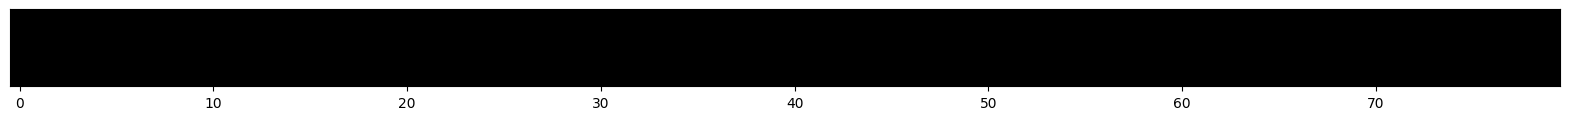

Mask in: original mask with 0.15 of observations masked out


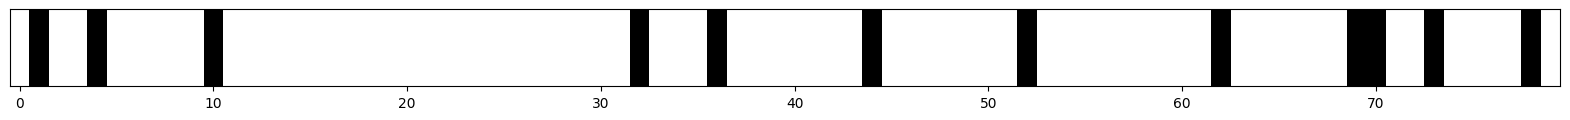

Mask pred: observations to be predicted


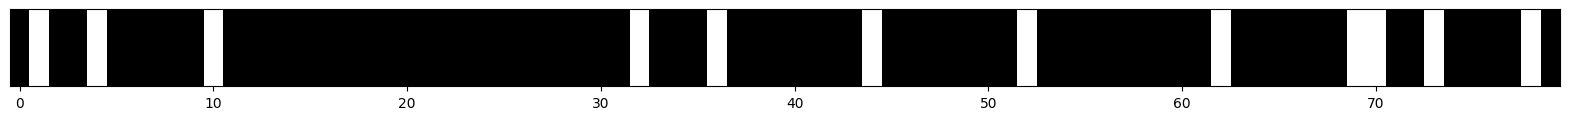

In [33]:
# Function to plot a mask
def plot_mask(mask):
    """ `mask` is a 1D boolean array.
    """
    plt.figure(figsize=(20, 1))
    plt.imshow(mask[None, :], aspect='auto', cmap='binary', vmin=0, vmax=1)
    plt.yticks([])
    plt.show()

print("Mask")
plot_mask(mask_test[0].detach().numpy())

print(f"Mask in: original mask with {f_mask} of observations masked out")
plot_mask(mask_in[0].detach().numpy())

print("Mask pred: observations to be predicted")
plot_mask(mask_pred[0].detach().numpy())

### Train masked autoencoder

In [51]:
class MaskedLightCurveEncoder(pl.LightningModule):
    def __init__(self, f_mask=0.2, transformer_kwargs={"n_out":1, "emb":128, "heads":2, "depth":4}, optimizer_kwargs={}, lr=1e-3):
        super().__init__()

        self.optimizer_kwargs = optimizer_kwargs
        self.lr = lr
        self.f_mask = f_mask

        self.net = TransformerWithTimeEmbeddings(**transformer_kwargs)

    def forward(self, x, t, mask=None):
        x = x[..., None]
        x = self.net(x, t, mask)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.RAdam(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        return {"optimizer": optimizer}

    def masked_pred(self, x, t, padding_mask, f_mask=0.15):
        # Get random mask and predict with masked inputs; then, return only the unmasked outputs
        mask_in, mask_pred = get_random_mask(padding_mask, f_mask=f_mask)
        x_masked = x.clone()
        x_masked[~mask_in] = 0
        x_pred = self(x_masked, t, mask=padding_mask)#[..., 0]  
        return x[mask_pred], x_pred[mask_pred]
    
    def training_step(self, batch, batch_idx):
        x, t, padding_mask = batch
        x, x_pred = self.masked_pred(x, t, padding_mask, f_mask=self.f_mask)
        loss = nn.MSELoss()(x, x_pred)
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True,)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t, padding_mask = batch
        x, x_pred = self.masked_pred(x, t, padding_mask, f_mask=self.f_mask)
        loss = nn.MSELoss()(x, x_pred)
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True,)
        return loss

In [54]:
mlce = MaskedLightCurveEncoder(f_mask=0.15, lr=6e-4, transformer_kwargs={"n_out":len(datas[0]), "emb":256, "heads":4, "depth":12, "dropout":0.02})

In [59]:
from torch.utils.data import TensorDataset, DataLoader, random_split

val_fraction = 0.05
batch_size = 64
n_samples_val = int(val_fraction * len(dataset))

#dataset = TensorDataset(mag, time, mask)

dataset_train, dataset_val = random_split(dataset, [len(dataset) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

In [68]:
trainer = pl.Trainer(max_epochs=200, accelerator='gpu',)
trainer.fit(model=mlce, train_dataloaders=train_loader, val_dataloaders=val_loader)

/n/home02/gemzhang/.local/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/home02/gemzhang/.local/lib/python3.10/site-packag ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-71cec993-9bd8-5ad8-a074-4d65704c8c52]

  | Name | Type                          | Params
-------------------------------------------------------
0 | net  | TransformerWithTimeEmbeddings | 9.5 M 
-------------------------------------------------------
9.5 M     Trainable params
0         Non-trainable params
9.5 M     Total params
37.956    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/n/home02/gemzhang/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 60:  63%|██████▎   | 47/75 [00:07<00:04,  6.17it/s, v_num=69, val_loss=3.41e+3, train_loss=3.4e+3] 

### Evaluation: mask-filling

In [ ]:
mlce = mlce.eval()

Let's see how well the encoder can fill in the masked parts of the light curves (set to zero, the special mask token) for the validation set.

In [62]:
mag_test, time_test, mask_test = next(iter(val_loader))

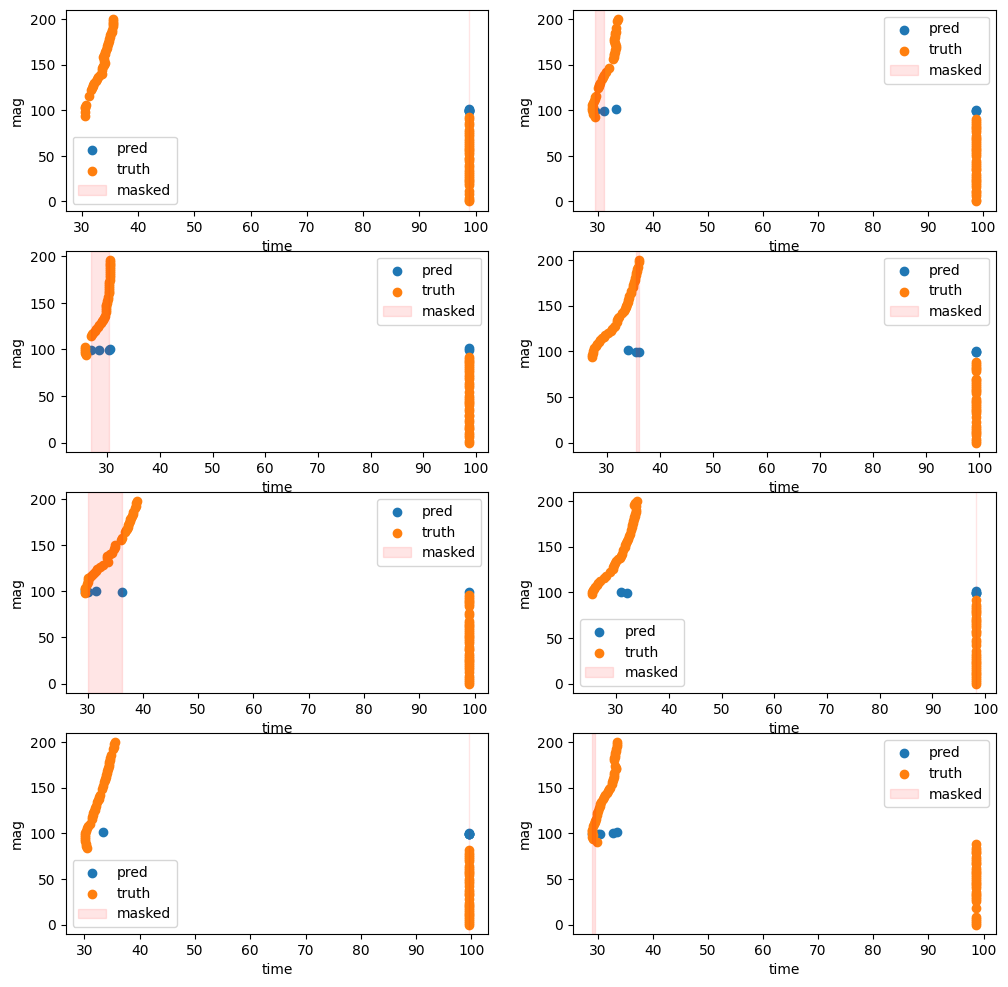

In [66]:
fig, ax = plt.subplots(4, 2, figsize=(12, 12))

for i in range(4):
    for j in range(2):
        ii = i * 2 + j

        fill_min, fill_max = 2, 7  # Mask out observations from fill_min to fill_max
        mask_tofill = mask_test[ii:ii + 1].clone()
        mask_tofill[:, fill_min:fill_max + 1] = False

        # Remove zero-padded, masked out elements
        mag_truth = mag_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]
        mag_test_in = mag_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]
        time_test_in = time_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]

        mag_test_in[fill_min:fill_max + 1] = 0

        mag_pred = mlce(mag_test_in[None, ...], time_test_in[None, ...], mask_test[ii:ii+1])[0].detach().numpy()[fill_min:fill_max + 1]

        ax[i, j].scatter(time_test_in[fill_min:fill_max + 1], mag_pred, label='pred')
        ax[i, j].scatter(time_test_in, mag_truth, label='truth')

        # Mark the masked observations; if fill_[min/max] is bigger than the number of observations, make it the length of the observations
        fill_min = min(fill_min, len(time_test_in) - 1)
        fill_max = min(fill_max, len(time_test_in) - 1)
        
        ax[i, j].axvspan(time_test_in[fill_min], time_test_in[fill_max], alpha=0.1, color='red', label='masked')
        ax[i, j].legend()

        ax[i, j].set_xlabel('time')
        ax[i, j].set_ylabel('mag')

Not great, but that was a very simple model. There seems to be an overall offset in the predictions! Can you improve the model and/or dataset? E.g.,
- We've standardized the light curves, so we don't have any information about their overall amplitude. That could explain the overall offset we're seeing above. How can you include this information in the model?
- We're only using r-band magnitudes. Can you use all available bands?
- Can you include information about magnitude errors?
- Can you improve the way time is embedded into the transformer (see references above)?